Larysa Nichypar, gr. 1 
nr. albumu: 455471

Projekt przejściowy
Analiza Zachowań Transakcyjnych Adresów Portfeli w Sieci Blockchain

## Wprowadzenie
W dzisiejszym dynamicznym świecie kryptowalut analiza zachowań transakcyjnych adresów portfeli w sieci blockchain staje się coraz bardziej istotna. Projekt ten zgłębia się w badanie portfeli, które zostały zgłoszone jako podejrzane. Analiza tych adresów może ujawnić nie tylko potencjalne przypadki nadużyć czy działalności przestępczej, ale także pomóc w identyfikacji wzorców zachowań charakterystycznych dla różnych typów użytkowników w ekosystemie kryptowalut.  

Pytania badawcze:  
- Jakie są charakterystyczne cechy i wzorce zachowań transakcyjnych wśród różnych adresów portfeli w sieci blockchain?  
- Jakie grupy adresów portfeli można zidentyfikować na podstawie ich podobnych zachowań transakcyjnych?  
- Jakie są liniowe i nieliniowe zależności między zmiennymi?  
  
Cele projektu:
1. Zidentyfikowanie ogólnych tendencji w rozkładzie liczby transakcji wśród różnych adresów portfela.  
2. Zrozumienie relacji między całkowitą kwotą otrzymaną a wysłaną dla każdego adresu portfela.  
3. Badanie zależności między liczbą transakcji a saldem końcowym na adresie portfela.  
4. Analiza korelacji między różnymi zmiennymi liczbowymi, takimi jak liczba transakcji, niezrealizowane transakcje, całkowita kwota otrzymana i wysłana, a saldo końcowe.  
5. Wykorzystanie analizy skupień do identyfikacji podobnych grup adresów portfeli na podstawie ich cech transakcyjnych.  
6. Porównanie wyników korelacji nieliniowej z korelacją liniową, aby zobaczyć, czy istnieją różnice w wykrywaniu związków między zmiennymi.

## Metody
Do zbierania danych na temat adresów portfeli oraz ich cech transakcyjnych wykorzystano narzędzie do web scrapingu dla przeglądarki Chrome, które umożliwiło szybkie i efektywne pobranie adresów portfeli z ostatniego roku ze strony internetowej chainabuse.com. Następnie pobrane adresy zostały przetworzone za pomocą skryptu w języku Python, który wykorzystał blockchain API do pobrania szczegółowych informacji na temat transakcji dla każdego adresu portfela.

## Cechy zbiora danych
Ten zbiór zawiera informacje dotyczące podejrzanych adresów portfeli w sieci blockchain. Każdy rekord odpowiada jednemu dresowi portfela i zawiera następujące atrybuty:
- address: Adres portfela.
- hash160: Skrót hash adresu portfela.
- n_tx: Liczba transakcji związanych z adresem portfela.
- n_unredeemed: Liczba nieodzyskanych transakcji.
- total_received: Łączna ilość otrzymanych środków na adresie portfela.
- total_sent: Łączna ilość wysłanych środków z adresu portfela.
- final_balance: Końcowy bilans adresu portfela.

Wyświetlimy kilka pierwszych wierszy tych danych.

In [26]:
# Użyte biblioteki
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import boxcox

In [18]:
file_path = 'C:/Users/Lara/AppData/Roaming/JetBrains/PyCharm2023.3/scratches/wallet_data.csv'
wallet_data = pd.read_csv(file_path)

print(wallet_data.head(10))

                                      address  \
0  bc1qydntupzckl7m09a5mvaqsh5wvhexkt0rrsfjth   
1          1L15W6b9vkxV81xW5HDtmMBycrdiettHEL   
2  bc1q6agcny78pv3jv0qu07ggf9splm5ftnrhc7u5w7   
3  bc1qdf7vsht0vdujptd4dmdzxytunfe04xgakylaau   
4          1MusKqjbk497v4Jf1bkgSpKb4aUhjzfoqA   
5           1iEMKaPqMp6zWv47UcPVzh7xzJvFvvZgx   
6  bc1qrxeecc52dfktp4qw32fpfmgwzn99udk3chr7va   
7          3MW6XZidVKCp4c5DxKR5v3KV9s4U5tAqwR   
8          1BQL3qBmL9JCT8BR9tihNx2y6vfHwCLt5s   
9  bc1qakythfv38ns2d9rrw2kyrlmctme9rp6cmqec7a   

                                    hash160    n_tx  n_unredeemed  \
0  2366be0458b7fdb797b4db3a085e8e65f26b2de3       2             0   
1  d06e25cef9c53166117ad37e4b704ceab914f55f  109450             3   
2  d7518993c70b23263c1c7f90849601fee895cc77       2             0   
3  6a7cc85d6f637920adb56eda23117c9a72fa991d       1             1   
4  e562279d37914a68e4af5ea40db8ccd1799f8b8e      10             2   
5  07cc32e0e1786de8a4b1f1a9eb10702381244d9f   

Wypełnimy czyszczenie danych w tym zbiorze: usuniemy brakujące wartości, duplikaty.

In [19]:
missing_values_before = wallet_data.isnull().sum().sum()
wallet_data.dropna(inplace=True)
duplicates_before = wallet_data.duplicated(subset='address').sum()
wallet_data.drop_duplicates(subset='address', keep='first', inplace=True)
missing_values_after = wallet_data.isnull().sum().sum()
duplicates_after = wallet_data.duplicated(subset='address').sum()
print(f"Usunięto brakujących wartości: {missing_values_before - missing_values_after}")
print(f"Usunięto duplikatów: {duplicates_before - duplicates_after}")

Usunięto brakujących wartości: 19
Usunięto duplikatów: 20


Usuńmy też adresy portfeli, które nie mają żadnych transakcji jako informacje nieistotne dla analizy, ktore mogą powodować niepotrzebne zakłócenie danych. W tej analizie chcemy skoncentrować się na aktywnych portfelach.

In [20]:
wallet_data = wallet_data[wallet_data['n_tx'] != 0]

Usuniemy też obserwacje odstające. Warto zbadać, czy istnieją wartości odstające w danych, które mogą wpłynąć na zależności między zmiennymi. Wartości odstające mogą prowadzić do fałszywych wniosków lub zakłócać analizę, dlatego ważne jest ich uwzględnienie i ewentualne ich usunięcie lub zrozumienie ich wpływu na wyniki.
Można wykorzystać metody uczenia maszynowego, które automatycznie identyfikują wartości odstające, na przykład algorytmy detekcji wartości odstających (np. Isolation Forest, Local Outlier Factor).

In [21]:
X = wallet_data[['n_tx', 'n_unredeemed', 'total_received', 'total_sent', 'final_balance']]
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto')
outliers = lof.fit_predict(X)
num_outliers = (outliers == -1).sum()
print("Liczba wartości odstających:", num_outliers)
mask = outliers != -1
wallet_data = wallet_data[mask]
print("Liczba wierszy po usunięciu wartości odstających:", len(wallet_data))

Liczba wartości odstających: 258
Liczba wierszy po usunięciu wartości odstających: 3812
                                      address  \
0  bc1qydntupzckl7m09a5mvaqsh5wvhexkt0rrsfjth   
2  bc1q6agcny78pv3jv0qu07ggf9splm5ftnrhc7u5w7   
4          1MusKqjbk497v4Jf1bkgSpKb4aUhjzfoqA   
5           1iEMKaPqMp6zWv47UcPVzh7xzJvFvvZgx   
6  bc1qrxeecc52dfktp4qw32fpfmgwzn99udk3chr7va   

                                    hash160  n_tx  n_unredeemed  \
0  2366be0458b7fdb797b4db3a085e8e65f26b2de3     2             0   
2  d7518993c70b23263c1c7f90849601fee895cc77     2             0   
4  e562279d37914a68e4af5ea40db8ccd1799f8b8e    10             2   
5  07cc32e0e1786de8a4b1f1a9eb10702381244d9f     4             0   
6  19b39c628a6a6cb0d40e8a9214ed0e14ca5e36d1    10             0   

   total_received  total_sent  final_balance  
0            4200        4200              0  
2      2499985369  2499985369              0  
4        15609165    15589185          19980  
5          110000      110

Sprawdzimy, czy rozkład danych jest normalny przez wykres kwantyl-kwantyl (Q-Q plot).

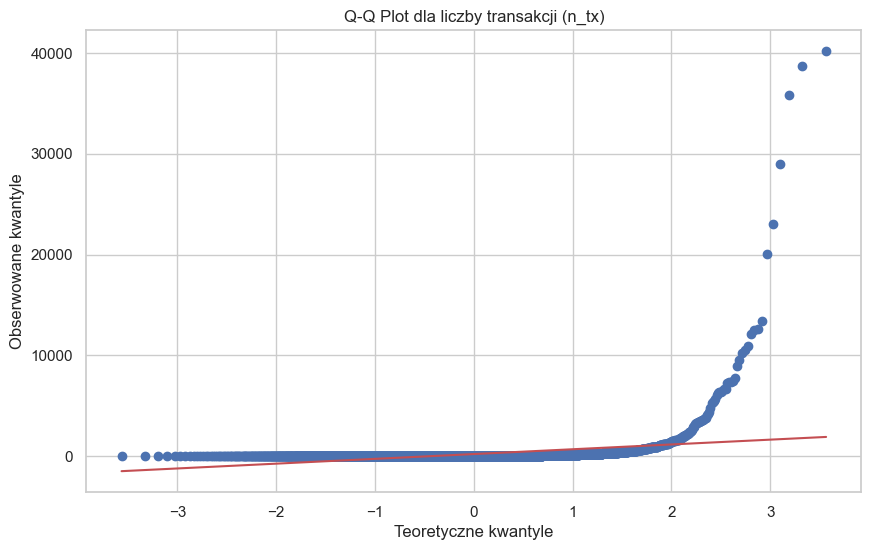

In [23]:
# Wykres kwantyl-kwantyl (Q-Q plot)
plt.figure(figsize=(10, 6))
stats.probplot(wallet_data['n_tx'], dist="norm", plot=plt)
plt.title('Q-Q Plot dla liczby transakcji (n_tx)')
plt.xlabel('Teoretyczne kwantyle')
plt.ylabel('Obserwowane kwantyle')
plt.show()


Danie nie są normalnie rozłożone, można zauważyć asymetriję lewostronną. W przypadku, gdy rozkład danych nie jest normalny, trzeba przeskalować dane w taki sposób, aby były bardziej odpowiednie do analizy. Użyjemy przekształcenie Boxa-Coxa. Ta metoda zmienia rozkład danych w sposób, który jest bliższy rozkładowi normalnemu. Dane o liczbie transakcji nie zawierają zer lub ujemnych wartości.

In [24]:
n_tx_values = wallet_data['n_tx']
transformed_n_tx, lambda_value = boxcox(n_tx_values)
print("Wartość lambda dla transformacji Boxa-Coxa:", lambda_value)

# Zapisujemy dane w nowej kolumnie
wallet_data['n_tx_transformed'] = transformed_n_tx

Wartość lambda dla transformacji Boxa-Coxa: -0.19141023853242087


## Analiza danych w zbiorze

In [43]:
# Użyte biblioteki
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

### Liczba Transakcji
Histogram przedstawia rozkład przeskalowanej liczby transakcji dla różnych adresów portfeli. Histogram pozwoli zidentyfikować ogólną tendencję w rozkładzie liczby transakcji wśród różnych adresów portfela.

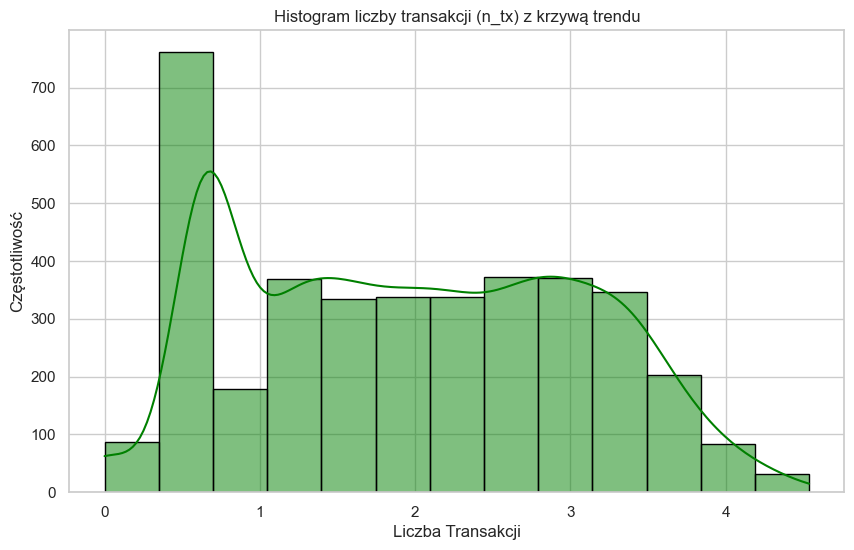

In [28]:
plt.figure(figsize=(10, 6))
sns.histplot(wallet_data['n_tx_transformed'], bins=13, color='green', edgecolor='black', kde=True)

plt.title('Histogram liczby transakcji (n_tx) z krzywą trendu')
plt.xlabel('Liczba Transakcji')
plt.ylabel('Częstotliwość')
plt.grid(True)
plt.show()

Rozkład ma prawostronna skośnośc. Częstotliwość w tym histogramie oznacza liczbę wystąpień danej liczby transakcji w zbiorze danych. Jest to miara, która informuje nas, jak często dana liczba transakcji występuje wśród wszystkich adresów portfela.  
Najwyższy słupek znajduje się w przedziale od 0 do 1 w przeskalowanych wartościach, co sugeruje, że dużo adresów portfeli w zbiorze danych ma niewielką liczbę transakcji. Adresy portfeli wykazują podobny poziom aktywności w przedziałach od 1 do ~3.5, co oznacza, że liczba transakcji dla większości adresów portfeli jest zbliżona w tych przedziałach przeskalowanych wartości.

Procentowy udział liczby adresów portfeli w grupie 1: 26.94
Procentowy udział liczby adresów portfeli w grupie 2: 73.06


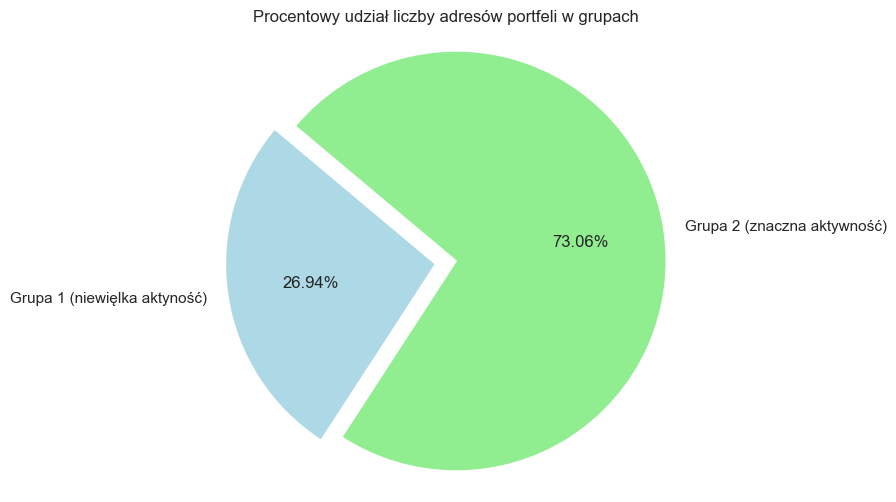

In [30]:
threshold = 1 # Prog dla liczby transakcji

# Podzielimy dane na dwie grupy na podstawie progu liczby transakcji
group1 = wallet_data[wallet_data['n_tx_transformed'] <= threshold]
group2 = wallet_data[wallet_data['n_tx_transformed'] > threshold]

# Obliczymy liczbę adresów portfeli dla każdej z grup
num_addresses_group1 = group1.shape[0]
num_addresses_group2 = group2.shape[0]

# Obliczymy procentowy udział liczby adresów portfeli w każdej grupie
total_addresses = num_addresses_group1 + num_addresses_group2
percentage_addresses_group1 = round((num_addresses_group1 / total_addresses) * 100, 2)
percentage_addresses_group2 = round((num_addresses_group2 / total_addresses) * 100, 2)

print("Procentowy udział liczby adresów portfeli w grupie 1:", percentage_addresses_group1)
print("Procentowy udział liczby adresów portfeli w grupie 2:", percentage_addresses_group2)

# Dane do wykresu kołowego
labels = ['Grupa 1 (niewięlka aktyność)', 'Grupa 2 (znaczna aktywność)']
sizes = [percentage_addresses_group1, percentage_addresses_group2]
colors = ['lightblue', 'lightgreen']
explode = (0.1, 0)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.2f%%', startangle=140)
plt.title('Procentowy udział liczby adresów portfeli w grupach')
plt.axis('equal')
plt.show()

W taki sposób, na histogramie i wykresie kołowym można zauważyć dwie grupy użytkowników: ci, którzy wykazują niewielką aktywność transakcyjną i dokonują transakcji sporadycznie (kolo 27%), oraz ci, którzy wykazują znaczną aktywność transakcyjną (kolo 73%).

### Total Received vs. Total Sent

Heatmapa przedstawia relację między całkowitą kwotą otrzymaną (Total Received) a całkowitą kwotą wysłaną (Total Sent) dla każdego adresu portfela. Heatmapa pozwoli zobaczyć gęstość punktów w obszarach, gdzie jest ich więcej, co może uwydatnić różnice między różnymi poziomami wartości. Obszary, gdzie punktów jest więcej, będą intensywniej kolorowane, podczas gdy obszary z mniejszą liczbą punktów będą miały jaśniejsze kolory.

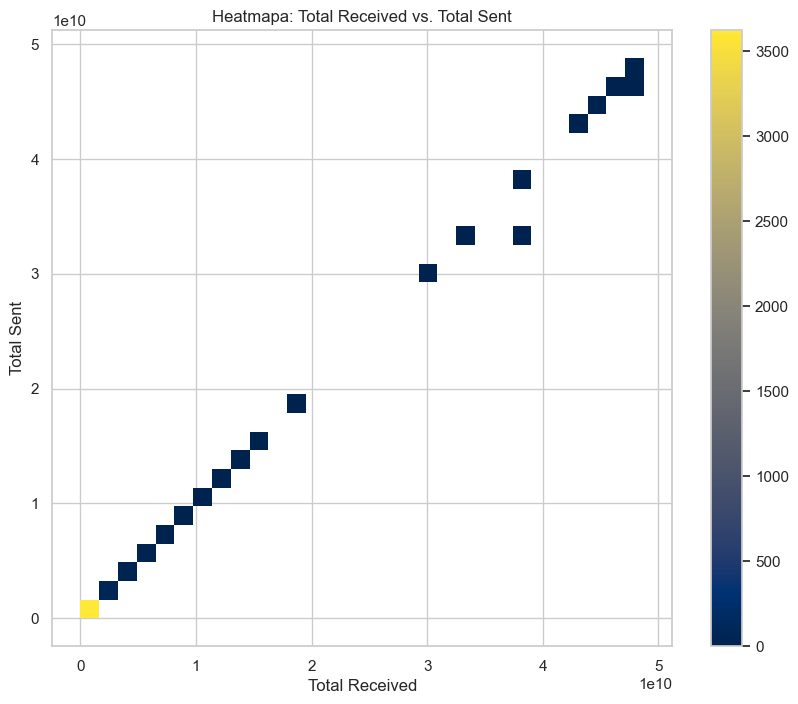

In [31]:
plt.figure(figsize=(10, 8))
sns.histplot(x=wallet_data['total_received'], y=wallet_data['total_sent'], bins=30, cmap='cividis', cbar=True)
plt.title('Heatmapa: Total Received vs. Total Sent')
plt.xlabel('Total Received')
plt.ylabel('Total Sent')
plt.grid(True)
plt.show()

Największa gęstość punktów (oznaczona kolorem ciemno-żołtym, maksymalna wartość na heatmapie) występuje w obszarze, gdzie wartości na osi X i Y są bliskie zeru (0.00). Oznacza to, że większość adresów portfeli otrzymała i wysłała dokładnie tyle samo środków, natomiast istnieją również adresy portfeli, które miały niewielkie różnice między ilością otrzymanych a wysłanych środków. Dodatkowo, występowanie adresów portfeli z większymi różnicami między ilością otrzymanych a wysłanych środków może wskazywać na pewne nietypowe zachowania lub zróżnicowanie aktywności finansowej w sieci blockchain.

### Liczba transakcji względem saldo końcowego 
Wykres punktowy pomoże zrozumieć zależność między saldem końcowym a liczbą transakcji.

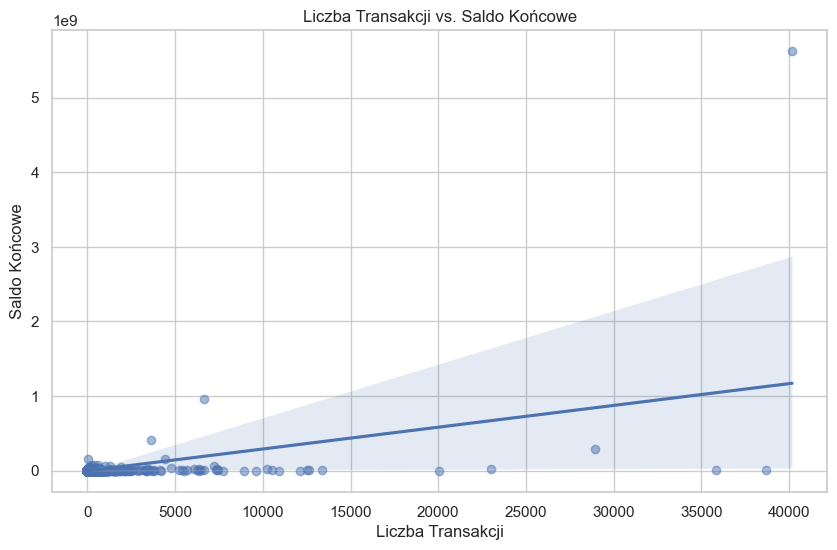

In [32]:
plt.figure(figsize=(10, 6))
sns.regplot(x=wallet_data['n_tx'], y=wallet_data['final_balance'], scatter_kws={'alpha':0.5})
plt.title('Liczba Transakcji vs. Saldo Końcowe')
plt.xlabel('Liczba Transakcji')
plt.ylabel('Saldo Końcowe')
plt.grid(True)
plt.show()

Linia trendu na wykresie punktowym ma słabe nachylenie, sugeruje to słabą lub umiarkowaną zależność liniową między zmiennymi. Należy zauważyć, że linia trendu na wykresie punktowym pokazuje ogólny trend danych, ale nie uwzględnia wszystkich nieliniowych zależności między zmiennymi ani występowania wartości odstających. Mimo braku korelacji liniowej, może istnieć inna zależność między zmiennymi.  
Czyli adresy z większą liczbą transakcji nie obowiązkowo mogą mieć szerszy zakres sald końcowych w porównaniu do adresów z mniejszą liczbą transakcji. Ten wynik prowadzi do dalszego badania korelacji zmiennych aby zidentyfikować typowe wzorce aktywności transakcyjnej.

### Heatmapy korelacji między różnymi zmiennymi
Korelacja między zmiennymi wskazuje na siłę i kierunek związku między nimi. Heatmapę korelacji dla wszystkich zmiennych liczbowych (n_tx, n_unredeemed, total_received, total_sent, final_balance) pozwoli zobaczyć, jak bardzo są one ze sobą powiązane. Wartości w zakresie od -1 do 1 wskazują na stopień korelacji między zmiennymi: im wartość korelacji między dwoma zmiennymi zbliża się do 1 (w przypadku korelacji dodatniej) lub -1 (w przypadku korelacji ujemnej), tym silniej są one ze sobą powiązane.

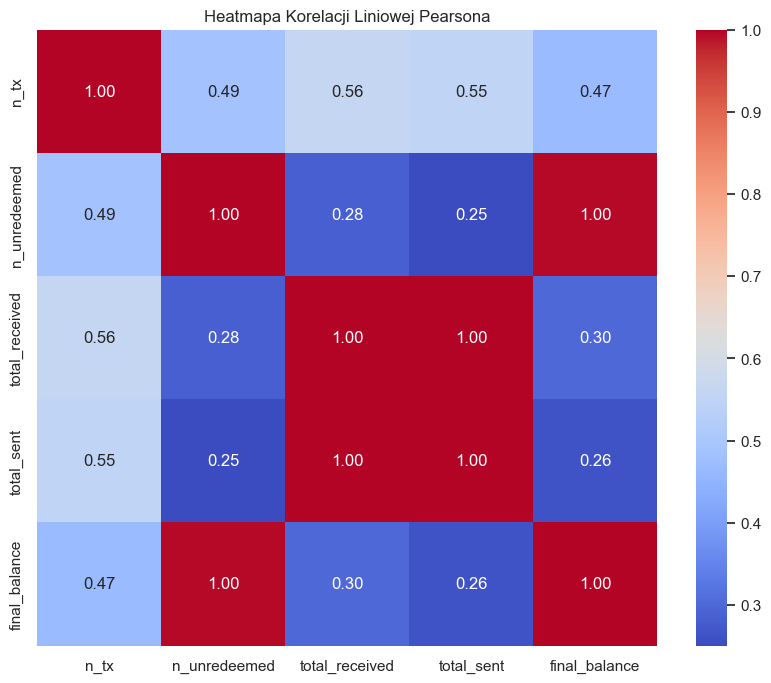

In [36]:
plt.figure(figsize=(10, 8))
corr_matrix = wallet_data[['n_tx', 'n_unredeemed', 'total_received', 'total_sent', 'final_balance']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmapa Korelacji Liniowej Pearsona')
plt.show()

Korelacja każdej zmiennej z samą sobą wynosi 1 (oczywiste, każda zmienna ma idealną korelację ze sobą samą).  
**n_tx** ma umiarkowaną dodatnią korelację (0.49) z **n_unredeemed**, co sugeruje, że liczba transakcji może być powiązana z liczbą niezrealizowanych transakcji w pewien sposób.  
**n_tx** ma umiarkowaną dodatnią korelację z **total_received** (0.56) i **total_sent** (0.55), co wskazuje na możliwy związek między liczbą transakcji a łączną kwotą otrzymaną i wysłaną.  
Korelacja **n_tx** z **final_balance** wynosi 0.47, co sugeruje też umiarkowaną dodatnią zależność między liczbą transakcji a saldem końcowym. 
**n_unredeemed** ma słabą korelację z **total_received** (0.28) i **total_sent** (0.25), co wskazuje na słabe powiązanie między liczbą niezrealizowanych transakcji a łączną kwotą otrzymaną i wysłaną.  
Korelacja **n_unredeemed** z **final_balance** wynosi 1, co sugeruje bardzo silną dodatnią zależność między liczbą niezrealizowanych transakcji a saldem końcowym. 
**total_received** i **total_sent** mają silną dodatnią korelację (1) między sobą, co sugeruje, że kwoty otrzymane i wysłane są bardzo silnie skorelowane ze sobą.
**total_received** i **total_sent** mają słabą dodatnią korelację (0.30 i 0.26) z **final_balance**, co sugeruje możliwe, ale słabe powiązanie między kwotami otrzymanymi i wysłanymi a saldem końcowym. 

Analiza adresów portfeli i ich transakcji w blockchainie może obejmować złożone wzorce zachowań, które nie zawsze mają liniowy charakter. Sprawdzenie innych typów korelacji, takich jak korelacja nieliniowa, może pomóc w identyfikacji zależności, które nie są liniowe. Do tego celu można użyć metod takich jak np. korelacja Spearmana lub korelacja Kendalla. Z uwagi na to, że analizujemy związki między zmiennymi w kontekście aktywności transakcyjnej, obie metody są równie użyteczne. Jednak korelacja Kendalla jest bardziej odporna na wartości odstające niż korelacja rangowa Spearmana, dlatego sprawdzimy ją.

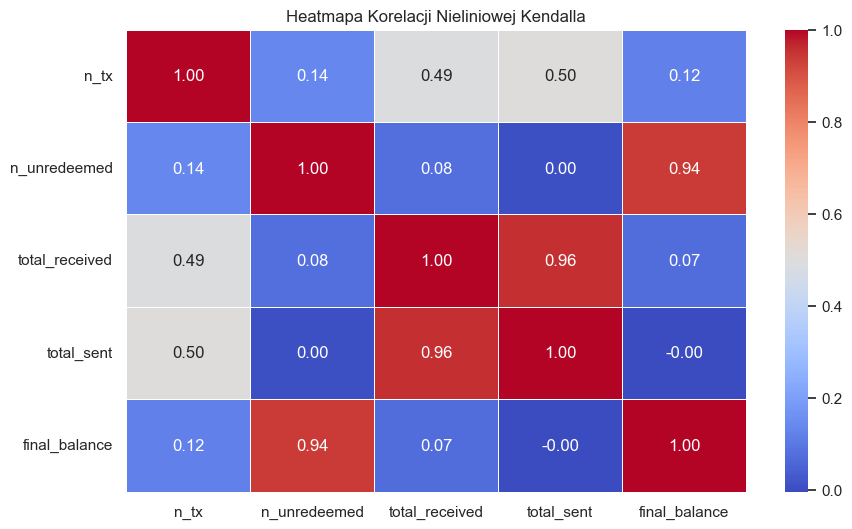

In [37]:
# Obliczamy korelację Kendalla
kendall_corr = wallet_data[['n_tx', 'n_unredeemed', 'total_received', 'total_sent', 'final_balance']].corr(method='kendall')

# Tworzymy wykres
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.heatmap(kendall_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmapa Korelacji Nieliniowej Kendalla')
plt.show()

Analizując te wyniki, można wywnioskować, że istnieją pewne zależności między badanymi zmiennymi, ale czasem nie są one bardzo silne.
Korelacja rangowa każdej zmiennej ze sobą samą wynosi 1, co jest oczywiste, ponieważ każda zmienna ma idealną korelację ze sobą samą.
Korelacja **n_tx** z **n_unredeemed** wynosi 0.14, co wskazuje na bardzo słabą dodatnią zależność rangową między liczbą transakcji a liczbą niezrealizowanych transakcji.
Korelacja **n_tx** z **total_received** i **total_sent** wynosi odpowiednio 0.49 i 0.50, co sugeruje umiarkowaną dodatnią zależność rangową między liczbą transakcji a łączną kwotą otrzymaną.
Korelacja **n_tx** z **final_balance** wynosi 0.12, co oznacza bardzo słabą dodatnią zależność między liczbą transakcji a saldem końcowym.
Korelacja **n_unredeemed** z **total_received** i **total_sent** wynosi 0.09 i 0.00 odpowiednio, co sugeruje brak istotnej zależności rangowej między liczbą niezrealizowanych transakcji a łączną kwotą otrzymaną i łączną kwotą wysłaną.
Korelacja **n_unredeemed** z **final_balance** wynosi 0.94, co oznacza bardzo silną dodatnią zależność rangową między liczbą niezrealizowanych transakcji a saldem końcowym.
Korelacja **total_received** z **total_sent** wynosi 0.96, co wskazuje na bardzo silną dodatnią zależność rangową między łączną kwotą otrzymaną a łączną kwotą wysłaną.
Korelacja **total_received** i **total_sent** z **final_balance** wynosi 0.07 i 0.00 odpowiednio, co sugeruje brak istotnej zależności rangowej między łączną kwotą otrzymaną i łączną kwotą wysłaną a saldem końcowym.

### Analiza skupień
Analiza skupień pozwala na identyfikację grup portfeli o podobnych zachowaniach transakcyjnych. Wykres radarowy przedstawia średnie wartości cech dla każdego klastra. Każdy klastr będzie miał swój własny wykres radarowy, co pozwoli na porównanie charakterystyk między grupami portfeli.

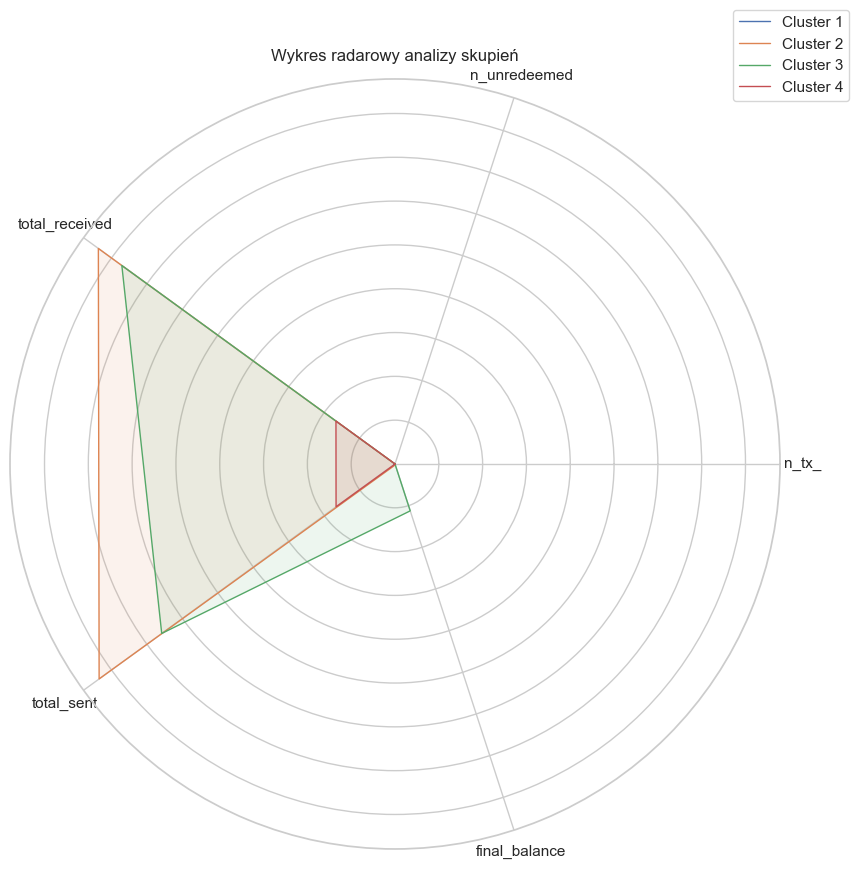

In [41]:
# Cechy do wyświetlenia na wykresie radarowym
features = ['n_tx_', 'n_unredeemed', 'total_received', 'total_sent', 'final_balance']

# Wybierzemy średnie wartości cech dla każdego klastra
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Wykres radarowy
num_clusters = len(cluster_centers)
angles = np.linspace(0, 2 * np.pi, len(features), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
for i in range(num_clusters):
    values = cluster_centers[i].tolist()
    values += values[:1]  # Pierwsza wartość jako ostatnia, aby zamknąć wykres
    ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {i+1}')
    ax.fill(angles, values, alpha=0.1)

ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(features)
plt.title('Wykres radarowy analizy skupień')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
plt.show()

Na wykresie pojawiło się 4 klastry, oznacza to, że dane zostały podzielone na 4 grupy na podstawie podobieństwa ich cech.  
Trójkąty między total_received a total_sent, różniące się rozmiarem, mogą oznaczać różne grupy lub klastry o różnych poziomach aktywności w odbieraniu i wysyłaniu transakcji, które mają podobne wartości dla total_received i total_sent, ale różnią się w innych zmiennych. Trójkąt o większym rozmiarze może sugerować większą różnorodność w wartościach pozostałych zmiennych w tej grupie w porównaniu do trójkątów o mniejszych rozmiarach.  
Trójkąt między total_sent a final_balance może reprezentować inną grupę lub klastrę, która ma zbliżone wartości dla total_sent i final_balance. Ta grupa może być bardziej zróżnicowana w wartościach pozostałych zmiennych.
Brak trójkątów między innymi zmiennymi sugeruje, że w analizie skupień te zmienne nie wpłynęły na podział danych na klastry, co może oznaczać, że dla tych klastrów wartości tych zmiennych są podobne.

## Ogólne wyniki badania
Charakterystyczne cechy transakcyjne obejmują liczbę transakcji, liczbę niezrealizowanych transakcji, łączną kwotę otrzymaną i wysłaną oraz saldo końcowe na adresach portfeli.  
Analiza liczby transakcji wskazuje, że mniejszość adresów portfeli wykazuje niewielką aktywność transakcyjną, podczas gdy większa grupa portfeli jest bardziej aktywna.  
Chociaż liczba transakcji wykazuje jedynie umiarkowaną korelację z saldem końcowym, istnieje tendencja do tego, że adresy portfeli z większą liczbą transakcji mogą mieć szerszy zakres sald końcowych w porównaniu do tych z mniejszą liczbą transakcji.  
Analiza relacji między całkowitą kwotą otrzymaną a wysłaną dla każdego adresu portfela sugeruje, że większość adresów portfeli ogólnie otrzymuje i wysyła podobne kwoty, ale istnieją również adresy z większymi różnicami między ilością otrzymanych a wysłanych środków, co może wskazywać na pewne trendy lub wzorce w zachowaniu finansowym.  
Analiza skupień wykazała, że dane można podzielić na cztery klasy na podstawie podobieństwa ich cech. To sugeruje istnienie różnorodnych grup adresów portfeli o podobnych wzorcach zachowań transakcyjnych.  
Korelacja między zmiennymi wykazuje zarówno zależności liniowe, jak i nieliniowe. Korelacja liniowa, wyrażona przez współczynniki regresji, sugeruje silne związki między niektórymi zmiennymi, np. total_received i total_sent. Korelacja nieliniowa, zbadana za pomocą korelacji Kendalla, też potwierdza pewne bardziej złożone związki między zmiennymi mimo zależności liniowych. Biorąc pod uwagę wystąpienie obu rodzajów korelacji dla tych samych zmiennych, można sugerować, że analiza powinna uwzględniać zarówno prostsze, liniowe zależności, jak i bardziej złożone, nieliniowe wzorce, aby pełniej zrozumieć naturę związku między tymi zmiennymi.